In [1]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from transformers import SamProcessor
from datasets import Dataset, Image, load_dataset, Features, Array3D, ClassLabel
from transformers import SamModel 
import loralib as lora
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings('ignore')

2024-05-28 22:02:12.605753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 22:02:13.470495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Advisors: Professor Cihang Xie and Professor Kuan Huang

Students: Josh Angel and Oliver Chang

# Motivation

Image segmentation has been in a variety of fields such as autonomous driving, medical imaging, and object-dection. Segment Anything (SA), by Meta, has further improved the vision-field by introducing the first segmentation foundation model. Segment Anything comprises of multiple promptable segmentation tasks, a transformer-based model, and data engine (providing 1+ billion masks and 11 million images). As such, Segment Anything boasts impressive zero-shot performances on novel datasets. 

We seek to apply SA to medical imagines. In particular, we segment COVID-19 chest x-ray scans from Qatar University & Tampere University & Hamad Medical Corporation. However, computationally fine-tuning a foundation model efficiently and tailored models like ViTDet-H still outperform SA's zero-shot capabilities stand in the way from accomplishing this task. Thus we turn to Low Rank Adaptation (LoRA) to efficiently fine-tune SAM on COVID-19 lung scans. 

# Dataset Preparation

We fine-tune SAM on QaTa-Covid19 dataset. This dataset features 7145 images and ground-truths (segmentation masks) for training and 2113 testing samples. Our task involves determining which regions in the chest x-ray show signs of COVID-19. Hence, we are classifying one mask for each image. 

While the original dataset in conveniently separated into a training and testing set, fine-tuning a model exclusively on the training set will overfit the model. As such, we further parition the training data into a train and validation set. The validation set will help determine if the model is overfitting.

In [2]:
## Helper functions
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    return dataset

def process_data(image_file, mask=False):
    image = PIL.Image.open(image_file)
    if not mask:
        image = image.convert("RGB")
    else:
        image = image.convert("L")
        image = image.point(lambda p: p > 0 and 1)
    image = image.resize((256, 256), PIL.Image.BILINEAR)
    return image

In [3]:
## Load in subset of raw data as numpy arrays
subset_size = 100
train_filelist_xray = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png'), key=numericalSort)
x_train = [process_data(file_xray) for file_xray in train_filelist_xray[:subset_size]]
masks = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png'), key=numericalSort)
y_train = [process_data(m, mask=True) for m in masks[:subset_size]]

In [4]:
## Make dataset dictionary
dataset = create_dataset(x_train, y_train)

## Sample Image
Below, we demonstate a sample image along with its ground-truth segmentation mask. 

(-0.5, 255.5, 255.5, -0.5)

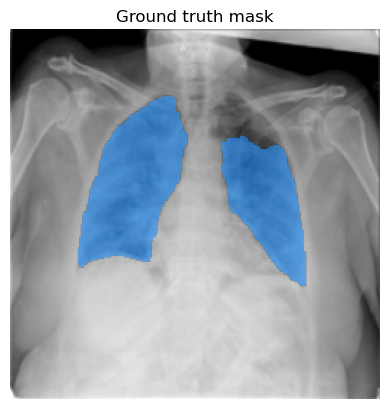

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
example = dataset[0]
image = example["image"]
fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes, False)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    if len(ground_truth_map) == 2:
        ground_truth_map = ground_truth_map[0]
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    return bbox

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
          
    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])
        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

# Segment Anything Model

In this section, we load in the pre-trained SAM model. We load the base version of sam, containing ~94 million parameters. This model is composed of three parts: the prompt encoder, vision encoder, and mask decoder. In this project, we make the parameters for the vision encoder and mask decoder tunable; the prompt encoder remains the constant.  

In [7]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [8]:
# Initialize Dataset
sam_dataset = SAMDataset(dataset=dataset, processor=processor)
# Define the size of the entire dataset and the proportions for splitting
dataset_size = len(sam_dataset)
train_size = int(dataset_size * 0.8)  # 80% for training
validation_size = dataset_size - train_size  # 20% for validation

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(sam_dataset, [train_size, validation_size])

# You can now use these in DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)

In [9]:
example = sam_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [11]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda:0")
# TODO: fine-tune vision encoder and add lora to MLP layers; train layernorm
for name, param in model.named_parameters():
  if name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [13]:
sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"SAM total params: {sam_total_params}")

SAM total params: 93729252


# Fine-tuning

We fine-tune the SAM model with LoRA for 10 epochs. Here are the hyperparameters we used:

- learning rate: 1e-5
- weight decay = 0
- Adam optimizer
- dice and cross entropy loss functions (by monai)
- epochs = 10
- 2 RTX 3090 GPUs
- n training samples are 100

It is important to note that for demonstration purposes, we showcase our approach on 100 training samples. A future direction in our work will include the entire dataset. 

In [14]:
from torch.optim import Adam
import monai
# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [15]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10
mean_epoch_losses = []
mean_epoch_val_losses = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    # Training phase
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()
      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
    # print statistics
    print(f'EPOCH: {epoch}')
    mean_loss = mean(epoch_losses)
    print(f'Mean loss: {mean_loss}')
    mean_epoch_losses.append(mean_loss)
    # Validation phase
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        for batch in validation_dataloader:  # Make sure to use your validation DataLoader
            # forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            epoch_val_losses.append(val_loss.item())
        # print statistics
        mean_val_loss = torch.mean(torch.tensor(epoch_val_losses))
        print(f'EPOCH {epoch}: Validation Mean loss: {mean_val_loss.item()}')
        mean_epoch_val_losses.append(mean_val_loss.item())

100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


EPOCH: 0
Mean loss: 0.45217489413917067
EPOCH 0: Validation Mean loss: 0.36026516556739807


100%|██████████| 40/40 [00:27<00:00,  1.48it/s]


EPOCH: 1
Mean loss: 0.32229266948997976
EPOCH 1: Validation Mean loss: 0.333342969417572


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


EPOCH: 2
Mean loss: 0.2901422638446093
EPOCH 2: Validation Mean loss: 0.31282109022140503


100%|██████████| 40/40 [00:26<00:00,  1.49it/s]


EPOCH: 3
Mean loss: 0.2453171856701374
EPOCH 3: Validation Mean loss: 0.31971147656440735


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


EPOCH: 4
Mean loss: 0.2363056167960167
EPOCH 4: Validation Mean loss: 0.28075355291366577


100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


EPOCH: 5
Mean loss: 0.22122596837580205
EPOCH 5: Validation Mean loss: 0.27499839663505554


100%|██████████| 40/40 [00:26<00:00,  1.52it/s]


EPOCH: 6
Mean loss: 0.20757461786270143
EPOCH 6: Validation Mean loss: 0.26904013752937317


100%|██████████| 40/40 [00:26<00:00,  1.52it/s]


EPOCH: 7
Mean loss: 0.19669734612107276
EPOCH 7: Validation Mean loss: 0.2835691273212433


100%|██████████| 40/40 [00:26<00:00,  1.51it/s]


EPOCH: 8
Mean loss: 0.17606394793838262
EPOCH 8: Validation Mean loss: 0.2590367794036865


100%|██████████| 40/40 [00:26<00:00,  1.52it/s]


EPOCH: 9
Mean loss: 0.16235898192971945
EPOCH 9: Validation Mean loss: 0.25279974937438965


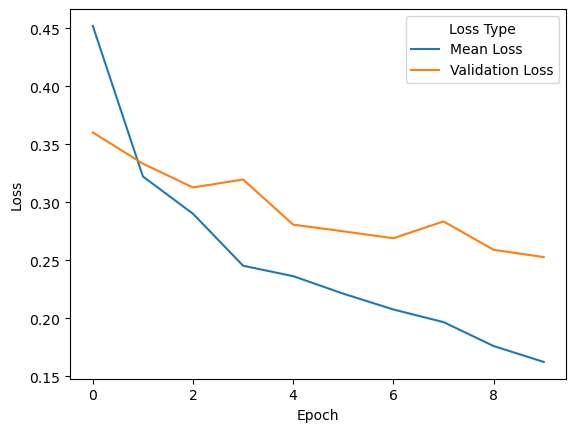

In [16]:
loss_df = {"Mean Loss": mean_epoch_losses,
           "Validation Loss": mean_epoch_val_losses}
loss_df = pd.DataFrame(loss_df).reset_index()
loss_df = loss_df.rename(columns={'index': 'Epoch'})
loss_df = loss_df.melt('Epoch', var_name='Loss Type',  value_name='Loss')
g = sns.lineplot(loss_df, x="Epoch", y="Loss", hue='Loss Type')

Across 10 epochs we see that the validation and episodic loss both tend downards, suggesting that the model is not overfitting the data.

We further compare our SAM integration with LoRA to the baseline SAM model. Here we train the models over 10 epochs. Observe that the episodic mean loss for baseline SAM it noticable lower than Lora SAM. We speculate that more training, data samples, and hyperparameter tuning can bring SAM + LoRA's loss even lower.

<Axes: xlabel='Epoch', ylabel='Mean Loss'>

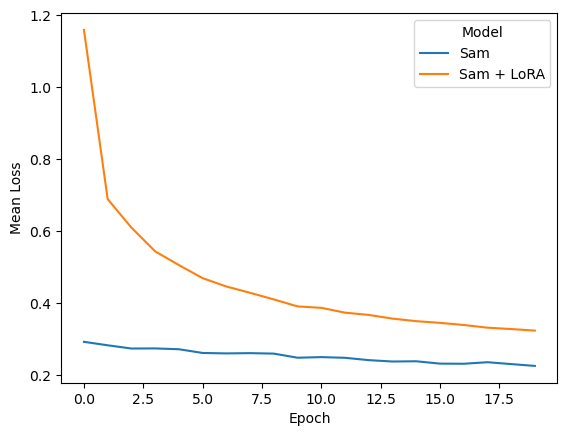

In [26]:
baseline_sam = pd.read_csv("sam_loss.csv", index_col=0)
lora_sam = pd.read_csv("lora_sam_loss.csv", index_col=0)
df = pd.concat([baseline_sam, lora_sam])
sns.lineplot(df, x='Epoch', y='Mean Loss', hue="Model")

# Inference

We test 100 samples and highlight one image with our newly-tuned model. 

In [20]:
def calculateIoU(gtMask, predMask):
        # Calculate the true positives,
        # false positives, and false negatives
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 1:
                    tp += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                    fp += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                    fn += 1
        # Calculate IoU
        iou = tp / (tp + fp + fn)
        return iou

In this particular case, the SAM + LoRA model does not successfully capture the ground-truth mask. A key shortcoming is how even central parts of the lung that should be classified as covid positive were not recognized.

## Inference Exam

Here we randomly select 100 test samples. SAM + Lora scored an average IOU of 31%. Baseline SAM scored an average IOU of 62%. Given that we trained on 100 datapoints, we find promise in the baseline SAM achieving a high mark.

In [21]:
## Load Test Set
subset_size = 100
test_filelist_xray = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/*.png'))
x_test = np.array([process_data(file_xray) for file_xray in test_filelist_xray[:subset_size]])

test_masks = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/*.png'))
y_test = np.array([process_data(m, mask=True) for m in test_masks[:subset_size]])
# binarize mask
y_test[y_test > 0] = 1 

print(f"Test data shape: {x_test.shape}")
print(f"Test labels (masks) data shape: {y_test.shape}")

Test data shape: (100, 256, 256, 3)
Test labels (masks) data shape: (100, 256, 256)


In [22]:
test_filelist_xray[:11]

['datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E16280_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E16628_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E16837_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17130_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17511_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17539_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17682_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17934_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E18100_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E26555_ru

In [23]:
test_masks[:11]

['datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E16280_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E16628_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E16837_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17130_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17511_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17539_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17682_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17934_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E1810

In [28]:
from datasets import Dataset, Image, load_dataset, Features, Array3D, ClassLabel
def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset
test_dataset = create_dataset(x_test, y_test)
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

In [29]:
test_ious = []
for idx, sample in enumerate(test_dataset):
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(sample["label"])
    prompt = get_bounding_box(ground_truth_mask)

    image = sample["image"]
    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    # forward pass
    with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    iou = calculateIoU(ground_truth_mask, medsam_seg)
    test_ious.append(iou)

In [30]:
print(f"Average IoUs over 100 test samples: {mean(test_ious)}")

Average IoUs over 100 test samples: 0.6441471154344153
